# TimeEval result comaprison

Reads the results from two TimeEval runs and compiles a small report. The report compares the results of the default parameter executions to those with optimized parameters. Change the constants and the configuration to compile the report for another TimeEval run.

In [1]:
# Automatically reload packages:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from pathlib import Path
from timeeval import Datasets

plt.rcParams["figure.figsize"] = (20, 8)

In [3]:
default_use_plotly = True
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

if default_use_plotly:
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots


def plot_bars(df, columns=[], agg="mean", use_plotly=default_use_plotly, title=""):
    if len(columns) == 0:
        raise ValueError("No columns selected!")
    df_tmp = df.pivot_table(index="algorithm", values=columns, aggfunc=agg)
    df_tmp = df_tmp.sort_values(by=columns[0], ascending=True, na_position="first")
    df_tmp.reset_index(drop=False, inplace=True)
    
    if use_plotly:
        return plot_bars_plotly(df_tmp, columns, title)
    else:
        return plot_bars_plt(df_tmp, columns, title)


def plot_bars_plotly(df, columns=[], title=""):
    fig = px.bar(df, x="algorithm", y=columns, barmode="group")
    fig.update_xaxes(tickangle=45)
    fig.update_layout(title={"text":title, "xanchor": "center", "x": 0.5}, yaxis_title="Metric", showlegend=True)
    return py.iplot(fig)

def plot_bars_plt(df, columns=[], title=""):
    fig, ax = plt.subplots(1, 1)
    if(len(columns)) > 2:
        raise ValueError("Cannot plot more than two bar charts!")
    for i, c in enumerate(columns):
        ax.bar(df["algorithm"], df[c], align="edge", width=-0.3 if i == 0 else 0.3, label=c)
    ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
    ax.set_title(title)
    ax.legend()
    return fig

## Configuration

In [4]:
# constants and configuration
data_path = Path("../../data") / "test-cases"
result_root_path = Path("../../results")
result_paths = [d for d in result_root_path.iterdir() if d.is_dir()]
result_paths

[PosixPath('../../results/2021-09-27_default-params-1&2&3&4-merged'),
 PosixPath('../../results/2021-10-18_runtime-gutentag')]

Select a results folder:

In [5]:
reference_result_path = result_root_path / "2021-09-27_default-params-1&2&3&4-merged"
optim_result_path = result_root_path / "2021-10-18_runtime-gutentag"

# load reference results
print(f"Reading reference results from {reference_result_path.resolve()}")
df_ref = pd.read_csv(reference_result_path / "results.csv")
df_ref["dataset_name"] = df_ref["dataset"].str.split(".").str[0]

# load optimized algorithms result path
print(f"Reading optimized results from {optim_result_path.resolve()}")
df_optim = pd.read_csv(optim_result_path / "results.csv")
df_optim["dataset_name"] = df_optim["dataset"].str.split(".").str[0]
df_optim.drop_duplicates(keep="first", inplace=True, ignore_index=True)

Reading reference results from /home/sebastian/Documents/Projects/akita/results/2021-09-27_default-params-1&2&3&4-merged
Reading optimized results from /home/sebastian/Documents/Projects/akita/results/2021-10-18_runtime-gutentag


Only consider the best run for each `algorithm`-`dataset`-combination (over all `hyper_params` and `repetition`s) for the analysis in this notebook:

In [6]:
def filter_groups(group):
    if len(group) > 1:
        group = group.sort_values(by="ROC_AUC", ascending=False)
    return group[:1]

df_grouped = df_ref.groupby(by=["algorithm", "collection", "dataset"])
df_grouped = df_grouped.apply(filter_groups)
df_grouped.reset_index(drop=True, inplace=True)
df_ref = df_grouped
df_ref = df_ref.sort_values(by=["algorithm", "dataset"])

## Compare TimeEval results on GutenTAG datasets

In [7]:
df_ref[["algorithm", "dataset_name", "status", "AVERAGE_PRECISION", "PR_AUC", "RANGE_PR_AUC", "ROC_AUC", "execute_main_time", "hyper_params"]]

,algorithm,dataset_name,status,AVERAGE_PRECISION,PR_AUC,RANGE_PR_AUC,ROC_AUC,execute_main_time,hyper_params
0,ARIMA,cbf-combined-diff-1,Status.OK,NaN,NaN,0.089392,0.531476,153.115361,"{""distance_metric"": ""euclidean"", ""max_lag"": 10..."
1,ARIMA,cbf-combined-diff-2,Status.OK,NaN,NaN,0.066603,0.452896,165.418194,"{""distance_metric"": ""euclidean"", ""max_lag"": 10..."
2,ARIMA,cbf-combined-diff-3,Status.OK,NaN,NaN,0.001155,0.214069,210.531216,"{""distance_metric"": ""euclidean"", ""max_lag"": 10..."
3,ARIMA,cbf-diff-count-1,Status.OK,NaN,NaN,0.005247,0.113232,115.612526,"{""distance_metric"": ""euclidean"", ""max_lag"": 10..."
4,ARIMA,cbf-diff-count-2,Status.OK,NaN,NaN,0.011949,0.507001,147.730167,"{""distance_metric"": ""euclidean"", ""max_lag"": 10..."
...,...,...,...,...,...,...,...,...,...
13101,normal,sinus-type-pattern-shift,Status.OK,0.01,0.505,0.505000,0.500000,0.000031,{}
13102,normal,sinus-type-pattern,Status.OK,0.01,0.505,0.505000,0.500000,0.000016,{}
13103,normal,sinus-type-platform,Status.OK,0.01,0.505,0.505000,0.500000,0.000021,{}
13104,normal,sinus-type-trend,Status.OK,0.01,0.505,0.505000,0.500000,0.000016,{}


In [8]:
df_optim[["algorithm", "dataset_name", "status", "AVERAGE_PRECISION", "PR_AUC", "RANGE_PR_AUC", "ROC_AUC", "execute_main_time", "hyper_params"]]

,algorithm,dataset_name,status,AVERAGE_PRECISION,PR_AUC,RANGE_PR_AUC,ROC_AUC,execute_main_time,hyper_params
0,ARIMA,cbf-combined-diff-1,Status.OK,0.454742,0.465248,0.453215,0.815319,78.018341,"{""differencing_degree"": 1, ""distance_metric"": ..."
1,ARIMA,cbf-combined-diff-2,Status.OK,0.068871,0.061556,0.077541,0.480169,134.534048,"{""differencing_degree"": 1, ""distance_metric"": ..."
2,ARIMA,cbf-combined-diff-3,Status.OK,0.241877,0.127965,0.136431,0.955978,130.194427,"{""differencing_degree"": 1, ""distance_metric"": ..."
3,ARIMA,cbf-diff-count-1,Status.OK,0.014368,0.008516,0.016521,0.439091,72.464707,"{""differencing_degree"": 1, ""distance_metric"": ..."
4,ARIMA,cbf-diff-count-2,Status.OK,0.011311,0.007510,0.012396,0.343218,107.627002,"{""differencing_degree"": 1, ""distance_metric"": ..."
...,...,...,...,...,...,...,...,...,...
10750,VALMOD,sinus-type-pattern-shift,Status.OK,0.370137,0.362852,0.368447,0.837476,37.700177,"{""exclusion_zone"": 0.5, ""heap_size"": 50, ""max_..."
10751,VALMOD,sinus-type-pattern,Status.OK,0.176112,0.171726,0.174526,0.448554,33.797723,"{""exclusion_zone"": 0.5, ""heap_size"": 50, ""max_..."
10752,VALMOD,sinus-type-platform,Status.OK,1.000000,1.000000,0.995026,1.000000,33.582908,"{""exclusion_zone"": 0.5, ""heap_size"": 50, ""max_..."
10753,VALMOD,sinus-type-trend,Status.ERROR,NaN,NaN,NaN,NaN,NaN,"{""exclusion_zone"": 0.5, ""heap_size"": 50, ""max_..."


#### Compute the score differences

In [9]:
key_columns = ["algorithm", "collection", "dataset_name"]
metric_columns = ["AVERAGE_PRECISION", "PR_AUC", "RANGE_PR_AUC", "ROC_AUC", "train_main_time", "execute_main_time"]
columns = key_columns + metric_columns
df = pd.merge(df_ref[columns], df_optim[columns], how="inner", on=key_columns, suffixes=("_ref", "_optim"))
df.fillna(0, inplace=True)

for mc in metric_columns:
    df[f"{mc}_diff"] = df[f"{mc}_optim"] - df[f"{mc}_ref"]
    df.drop(columns=[f"{mc}_ref", f"{mc}_optim"], inplace=True)
df

,algorithm,collection,dataset_name,AVERAGE_PRECISION_diff,PR_AUC_diff,RANGE_PR_AUC_diff,ROC_AUC_diff,train_main_time_diff,execute_main_time_diff
0,ARIMA,GutenTAG,cbf-combined-diff-1,0.454742,0.465248,0.363823,0.283843,0.0,-75.097020
1,ARIMA,GutenTAG,cbf-combined-diff-2,0.068871,0.061556,0.010938,0.027273,0.0,-30.884145
2,ARIMA,GutenTAG,cbf-combined-diff-3,0.241877,0.127965,0.135276,0.741909,0.0,-80.336789
3,ARIMA,GutenTAG,cbf-diff-count-1,0.014368,0.008516,0.011273,0.325859,0.0,-43.147819
4,ARIMA,GutenTAG,cbf-diff-count-2,0.011311,0.007510,0.000447,-0.163783,0.0,-40.103166
...,...,...,...,...,...,...,...,...,...
10356,k-Means,GutenTAG,sinus-type-pattern-shift,-0.032091,-0.032544,-0.008014,-0.000149,0.0,45.251641
10357,k-Means,GutenTAG,sinus-type-pattern,0.999901,0.999900,-0.000035,-0.000001,0.0,50.553484
10358,k-Means,GutenTAG,sinus-type-platform,-0.027792,-0.024494,0.086535,-0.000753,0.0,32.716808
10359,k-Means,GutenTAG,sinus-type-trend,0.000000,0.000000,0.000043,0.000000,0.0,16.612107


#### Overall algorithm performance change

In [10]:
aggregations = ["mean", "median"]
df_overall_scores = df.pivot_table(index="algorithm", values=[f"{m}_diff" for m in metric_columns], aggfunc=aggregations)
df_overall_scores = df_overall_scores.sort_values(by=("mean", "ROC_AUC_diff"), ascending=False)

df_overall_scores.head()

mean                                \
               AVERAGE_PRECISION_diff PR_AUC_diff RANGE_PR_AUC_diff   
algorithm                                                             
NormA                        0.421635    0.421323          0.367889   
VALMOD                       0.467986    0.466987          0.011349   
PhaseSpace-SVM               0.497796    0.512652          0.187967   
HOT SAX                      0.205895    0.207606          0.113128   
ARIMA                        0.348697    0.353508          0.150179   

                                                                         \
               ROC_AUC_diff execute_main_time_diff train_main_time_diff   
algorithm                                                                 
NormA              0.265064               2.085377                  0.0   
VALMOD             0.165910              31.401900                  0.0   
PhaseSpace-SVM     0.164920              16.173163                  0.0   
HOT SAX            0.135798             -68.288820                  0.0   
ARIMA              0.127298              20.188411                  0.0   

                               median                                \
               AVERAGE_PRECISION_diff PR_AUC_diff RANGE_PR_AUC_diff   
algorithm                                                             
NormA                        0.179740    0.177563          0.235541   
VALMOD                       0.455776    0.455548          0.000002   
PhaseSpace-SVM               0.578823    0.578764          0.142633   
HOT SAX                      0.031202    0.020028          0.000000   
ARIMA                        0.266359    0.263341          0.046071   

                                                                         
               ROC_AUC_diff execute_main_time_diff train_main_time_diff  
algorithm                                                                
NormA              0.310973               1.248615                  0.0  
VALMOD             0.000003              35.510810                  0.0  
PhaseSpace-SVM     0.121838              -5.222175                  0.0  
HOT SAX            0.048124               0.000000                  0.0  
ARIMA              0.105241             -92.444743                  0.0

#### AUC_ROC change per algorithm

In [11]:
df_asl = df.pivot(index="algorithm", columns="dataset_name", values="ROC_AUC_diff")
df_asl = df_asl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_asl["median"] = df_asl.median(axis=1)
df_asl = df_asl.sort_values(by="median", ascending=True)
df_asl = df_asl.drop(columns="median").T

In [12]:
if default_use_plotly:
    fig = go.Figure()
    for c in df_asl.columns:
        fig.add_trace(go.Violin(
            y=df_asl[c],
            name=c
        ))
    fig.update_traces(meanline_visible=True, box_visible=True)
    fig.update_layout(
        title={"text":"Change in AUC_ROC", "xanchor": "center", "x": 0.5},
        yaxis_title="AUC_ROC score",
        legend_title="Algorithms",
        violingap=0
    )
    py.iplot(fig)

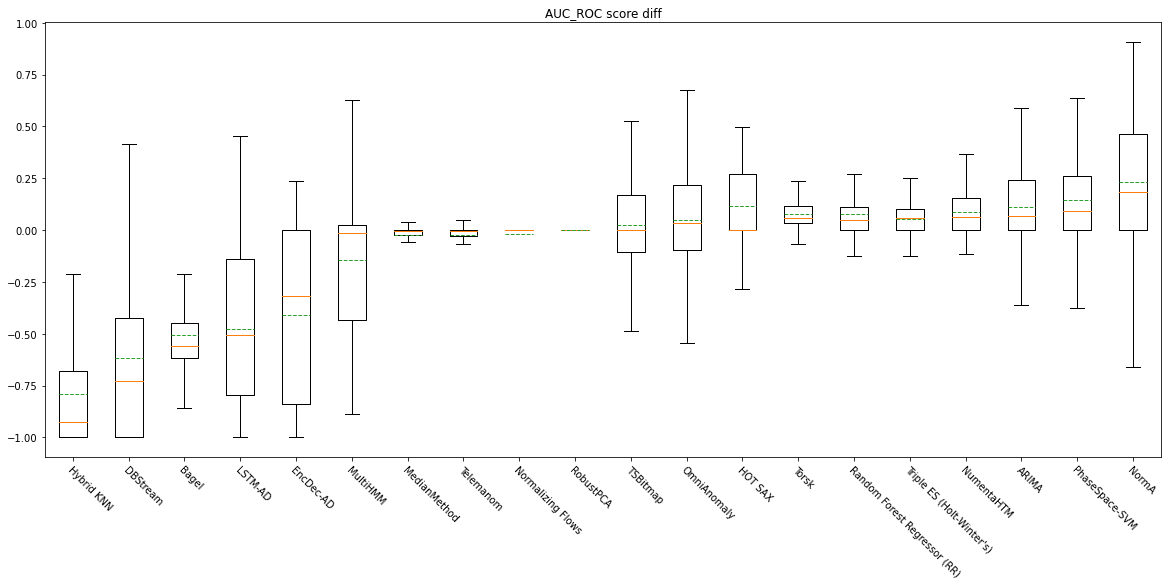

In [13]:
n_show = 20
n_show = n_show // 2

if default_use_plotly:
    fig = go.Figure()
    for i, c in enumerate(df_asl.columns):
        fig.add_trace(go.Box(
            x=df_asl[c],
            name=c,
            boxpoints=False,
            visible=None if i < n_show or i > len(df_asl.columns)-n_show-1 else "legendonly"
        ))
    fig.update_layout(
        title={"text":"AUC_ROC box plots", "xanchor": "center", "x": 0.5},
        xaxis_title="AUC_ROC score diff",
        legend_title="Algorithms"
    )
    py.iplot(fig)
else:
    df_tmp = df_asl.fillna(0)
    df_tmp = df_tmp[list(df_tmp.columns)[:n_show]+list(df_tmp.columns)[-n_show:]]
    plt.boxplot(df_tmp, vert=True, labels=df_tmp.columns, meanline=True, showmeans=True, showfliers=False, manage_ticks=True)
    plt.xticks(rotation=-45, ha="left", rotation_mode="anchor")
    plt.title("AUC_ROC score diff")
    plt.show()

/tmp/ipykernel_32339/4050411280.py:40: UserWarning:

FixedFormatter should only be used together with FixedLocator



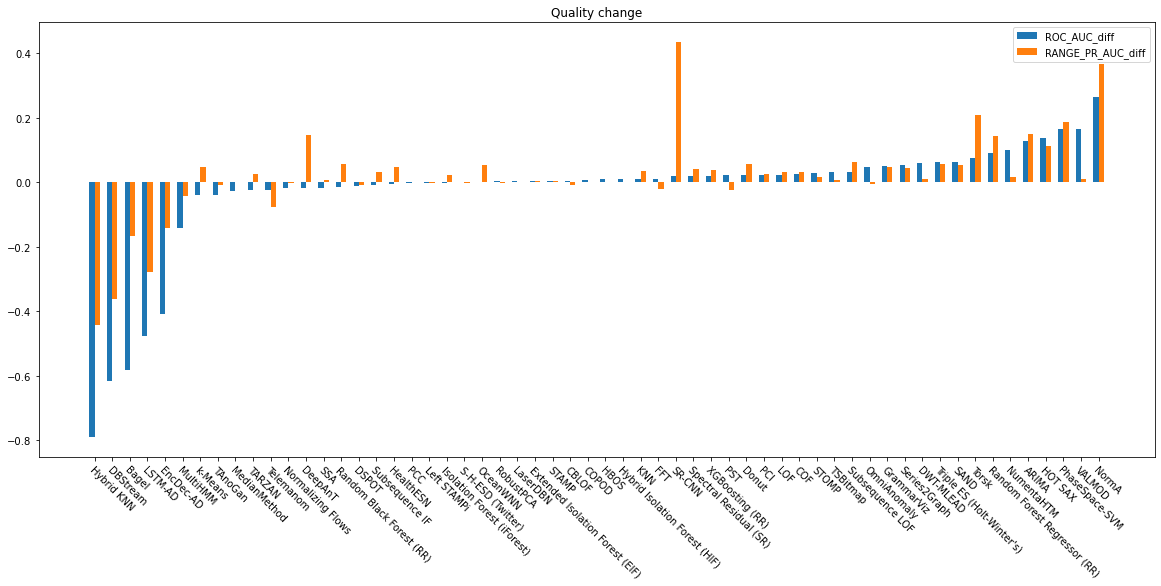

In [14]:
plot_bars(df, columns=["ROC_AUC_diff", "RANGE_PR_AUC_diff"], title="Quality change")
plt.show()

#### Look into algorithms whose performance degraded

- Hybrid KNN --> **rerun**
- DBStream --> **rerun**
- Bagel --> **rerun**
- LSTM-AD --> **rerun**
- EncDec-AD --> keep
- MultiHMM --> **rerun**

Errors and timeouts:

In [15]:
def list_parameters(algo):
    print(f"Parameters of {algo}:")
    ref_params = df_ref[df_ref["algorithm"] == algo]["hyper_params"].unique()
    print("\n### Ref:")
    param_d = {}
    for param_set in ref_params:
        param_set = json.loads(param_set)
        for param in param_set:
            if param not in param_d:
                param_d[param] = []
            param_d[param].append(param_set[param])
    for param in sorted(param_d):
        print(f"  {param}: {np.unique(param_d[param])}")

    optim_params = df_optim[df_optim["algorithm"] == algo]["hyper_params"].unique()
    print("\n### Optim:")
    param_d = {}
    for param_set in optim_params:
        param_set = json.loads(param_set)
        for param in param_set:
            if param not in param_d:
                param_d[param] = []
            param_d[param].append(param_set[param])
    for param in sorted(param_d):
        print(f"  {param}: {np.unique(param_d[param])}")

In [16]:
algo_list = ["Hybrid KNN", "DBStream", "Bagel", "LSTM-AD", "EncDec-AD", "MultiHMM"]

df_tmp = pd.DataFrame(columns=["Status.OK", "Status.ERROR", "Status.TIMEOUT"], index=pd.MultiIndex.from_product([algo_list, ["ref", "optim"]], names=["algo", "exp"]))
for algo in algo_list:
    df_tmp.loc[(algo, "ref"), :] = df_ref[df_ref["algorithm"] == algo].groupby(by=["status"])["repetition"].count()
    df_tmp.loc[(algo, "optim"), :] = df_optim[df_optim["algorithm"] == algo].groupby(by=["status"])["repetition"].count()
df_tmp.fillna(0, inplace=True)
df_tmp.T

algo           Hybrid KNN        DBStream         Bagel        LSTM-AD         \
exp                   ref  optim      ref  optim    ref  optim     ref  optim   
Status.OK           193.0   12.0    169.0   22.0  168.0    0.0   193.0   75.0   
Status.ERROR          0.0  181.0     24.0  171.0    0.0  168.0     0.0  111.0   
Status.TIMEOUT        0.0    0.0      0.0    0.0    0.0    0.0     0.0    7.0   

algo           EncDec-AD        MultiHMM         
exp                  ref  optim      ref  optim  
Status.OK          134.0   17.0    150.0   81.0  
Status.ERROR        49.0   39.0     43.0  112.0  
Status.TIMEOUT      10.0  137.0      0.0    0.0

##### Hybrid KNN

Error message:

```
/usr/local/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
Traceback (most recent call last):
  File "/app/algorithm.py", line 79, in <module>
    train(args)
  File "/app/algorithm.py", line 55, in train
    model.fit(data, args.modelOutput)
  File "/app/hybrid_knn/hybrid_knn.py", line 39, in fit
    self.dae.fit(X, callbacks=[knn_callback, save_callback])
  File "/app/hybrid_knn/dae/dae.py", line 113, in fit
    early_stopping.update(validation_loss)
  File "/app/hybrid_knn/dae/early_stopping.py", line 28, in update
    self._callback(improvement, loss)
  File "/app/hybrid_knn/dae/early_stopping.py", line 17, in _callback
    cb(improvement, loss, self.epochs_without_change)
  File "/app/hybrid_knn/hybrid_knn.py", line 33, in knn_callback
    self.knn.fit(self.dae.reduce(X))
  File "/app/hybrid_knn/knn/knn.py", line 20, in fit
    self.g = [self._calculate_kth_distance(s) for s in self.s]
  File "/app/hybrid_knn/knn/knn.py", line 20, in <listcomp>
    self.g = [self._calculate_kth_distance(s) for s in self.s]
  File "/app/hybrid_knn/knn/knn.py", line 27, in _calculate_kth_distance
    d[:, l] = knn.kth_neighbor_distance(X)
  File "/app/hybrid_knn/knn/knn.py", line 50, in kth_neighbor_distance
    distances, _ = self.nbrs.kneighbors(X, self.k, return_distance=True)
  File "/usr/local/lib/python3.7/site-packages/sklearn/neighbors/_base.py", line 683, in kneighbors
    (n_samples_fit, n_neighbors)
ValueError: Expected n_neighbors <= n_samples,  but n_samples = 9, n_neighbors = 10
```

In [17]:
list_parameters("Hybrid KNN")

Parameters of Hybrid KNN:

### Ref:
  anomaly_window_size: [   1   10   50  100  200  500 1000]
  batch_size: [64]
  early_stopping_delta: [0.05]
  early_stopping_patience: [10]
  epochs: [500]
  learning_rate: [0.001]
  random_state: [42]
  split: [0.8]
  test_batch_size: [64]

### Optim:
  anomaly_window_size: [   1   10   50  100  200  500 1000]
  batch_size: [64]
  early_stopping_delta: [0.05]
  early_stopping_patience: [10]
  epochs: [500]
  learning_rate: [0.001]
  n_estimators: [1000]
  n_neighbors: [10]
  random_state: [42]
  split: [0.8]
  test_batch_size: [64]


--> Parameter configuration error: Combination of `n_estimators=1000` and `n_neighbors=10` is too large for the number of samples in our datasets.

--> **reduced to `n_estimators=500` and `n_neighbors=10`**

##### DBStream

Error message:

```
Error in cutree(hc, k = k) : elements of 'k' must be between 1 and 33
```

In [18]:
list_parameters("DBStream")

Parameters of DBStream:

### Ref:
  distance_metric: ['euclidean']
  random_state: [42]
  window_size: [ 12  22  30  64 150]

### Optim:
  alpha: [0.5]
  distance_metric: ['euclidean']
  lambda: [0.001]
  min_weight: [0]
  n_clusters: [50]
  radius: [1.3]
  random_state: [42]
  shared_density: [ True]
  window_size: [  8  15  20  43 100]


--> Parameter configuration error: `n_clusters` must be below 33 and `50` is too large!

--> **reduced to `n_clusters=30`**

##### Bagel

Error message:

```
Traceback (most recent call last):
  File "/app/algorithm.py", line 117, in <module>
    train(args, kpi)
  File "/app/algorithm.py", line 84, in train
    early_stopping_patience=cp.early_stopping_patience
  File "/app/bagel/model.py", line 104, in __init__
    self.window_size + self.condition_size, self.latent_dims, self.network_size, eps=1e-4),
  File "/app/bagel/network/fc_gaussian_statistic.py", line 26, in __init__
    for current_size in net_size:
TypeError: 'int' object is not iterable
```

In [19]:
list_parameters("Bagel")

Parameters of Bagel:

### Ref:
  cuda: [False]
  early_stopping_delta: [0.05]
  early_stopping_patience: [10]
  epochs: [500]
  random_state: [42]
  split: [0.8]

### Optim:
  batch_size: [64]
  cuda: [False]
  dropout: [0.1]
  early_stopping_delta: [0.05]
  early_stopping_patience: [10]
  epochs: [500]
  hidden_layer_shape: [100]
  latent_size: [6]
  random_state: [42]
  split: [0.8]
  window_size: [ 16  30  40  86 200]


--> `AlgorithmConfigurator` was assuming that `hidden_layer_shape: [100, 100]` is a search space instead of a single parameter value. This is also the reason, why there are duplicates!

--> **fixed `AlgorithmConfigurator`!**

##### LSTM-AD

OOM (`status code '137'`) for most datasets, but for multivariate ones, we also get:

```
/usr/local/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
Traceback (most recent call last):
  File "/app/algorithm.py", line 76, in <module>
    train(args)
  File "/app/algorithm.py", line 52, in train
    model.fit(data, args.modelOutput)
  File "/app/lstm_ad/model.py", line 125, in fit
    early_stopping.update(validation_loss)
  File "/app/lstm_ad/early_stopping.py", line 28, in update
    self._callback(improvement, loss)
  File "/app/lstm_ad/early_stopping.py", line 17, in _callback
    cb(improvement, loss, self.epochs_without_change)
  File "/app/lstm_ad/model.py", line 104, in cb
    self._estimate_normal_distribution(valid_dl)
  File "/app/lstm_ad/model.py", line 138, in _estimate_normal_distribution
    e = torch.abs(y[:, -1, :] - y_hat)
RuntimeError: The size of tensor a (3) must match the size of tensor b (150) at non-singleton dimension 1
```

Exemplary datasets with this error:

- sinus-channels-all-of-3.semi-supervised
- cbf-channels-all-of-3.semi-supervised
- ecg-channels-single-of-5.semi-supervised

In [20]:
list_parameters("LSTM-AD")

Parameters of LSTM-AD:

### Ref:
  batch_size: [64]
  early_stopping_delta: [0.05]
  early_stopping_patience: [10]
  epochs: [500]
  learning_rate: [0.001]
  random_state: [42]
  split: [0.8]
  test_batch_size: [64]
  validation_batch_size: [64]
  window_size: [ 12  22  30  64 150]

### Optim:
  batch_size: [64]
  early_stopping_delta: [0.05]
  early_stopping_patience: [10]
  epochs: [500]
  learning_rate: [0.001]
  lstm_layers: [1]
  prediction_window_size: [50]
  random_state: [42]
  split: [0.8]
  test_batch_size: [64]
  validation_batch_size: [64]
  window_size: [ 16  30  40  86 200]


--> **OOM** error is unfortunate, but nothing we can change!

--> the shape error on multivariate datasets seems to be due to a change of parameter `prediction_window_size` from `1` to `50`

##### EncDec-AD

--> Reduced performance due to a lot of **timeout**s. Errors decreased.

--> **no change necessary**

##### MultiHMM

87 error messages:

```
Traceback (most recent call last):
  File "/app/algorithm.py", line 73, in <module>
    execute(args)
  File "/app/algorithm.py", line 54, in execute
    model = joblib.load(args.modelInput)
  File "/usr/local/lib/python3.7/site-packages/joblib/numpy_pickle.py", line 585, in load
    obj = _unpickle(fobj, filename, mmap_mode)
  File "/usr/local/lib/python3.7/site-packages/joblib/numpy_pickle.py", line 504, in _unpickle
    obj = unpickler.load()
  File "/usr/local/lib/python3.7/pickle.py", line 1088, in load
    dispatch[key[0]](self)
  File "/usr/local/lib/python3.7/site-packages/joblib/numpy_pickle.py", line 329, in load_build
    Unpickler.load_build(self)
  File "/usr/local/lib/python3.7/pickle.py", line 1552, in load_build
    setstate(state)
  File "/app/multi_hmm/model.py", line 35, in __setstate__
    self.hmm = pg.HiddenMarkovModel.from_json(self.hmm)
  File "pomegranate/base.pyx", line 97, in pomegranate.base.Model.from_json
  File "pomegranate/hmm.pyx", line 3264, in pomegranate.hmm.HiddenMarkovModel.from_dict
  File "pomegranate/base.pyx", line 504, in pomegranate.base.State.from_dict
  File "pomegranate/distributions/distributions.pyx", line 303, in pomegranate.distributions.distributions.Distribution.from_dict
  File "<string>", line 1, in <module>
NameError: name 'nan' is not defined
```

25 error messages (on multivariate datasets):

```
Traceback (most recent call last):
  File "/app/algorithm.py", line 71, in <module>
    train(args)
  File "/app/algorithm.py", line 48, in train
    model.fit(data, labels)
  File "/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/usr/local/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py", line 387, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/site-packages/sklearn/base.py", line 702, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py", line 153, in fit
    X = self._validate_data(X, dtype='numeric')
  File "/usr/local/lib/python3.7/site-packages/sklearn/base.py", line 421, in _validate_data
    X = check_array(X, **check_params)
  File "/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py", line 698, in check_array
    "if it contains a single sample.".format(array))
ValueError: Expected 2D array, got 1D array instead:
array=[-0.11283424  1.73056285  3.66144375 ... -0.25435671 -0.27262701
 -0.27213188].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
```

In [21]:
list_parameters("MultiHMM")

Parameters of MultiHMM:

### Ref:
  random_state: [42]

### Optim:
  discretizer: ['choquet']
  n_bins: [5]
  random_state: [42]


--> **fixed multivariate dataset error**

--> **won't fix nan-error** (issue ref: [akita/timeeval-algorithms#45](https://gitlab.hpi.de/akita/timeeval-algorithms/-/issues/45))

#### Runtime change per algorithm

/tmp/ipykernel_32339/4050411280.py:40: UserWarning:

FixedFormatter should only be used together with FixedLocator



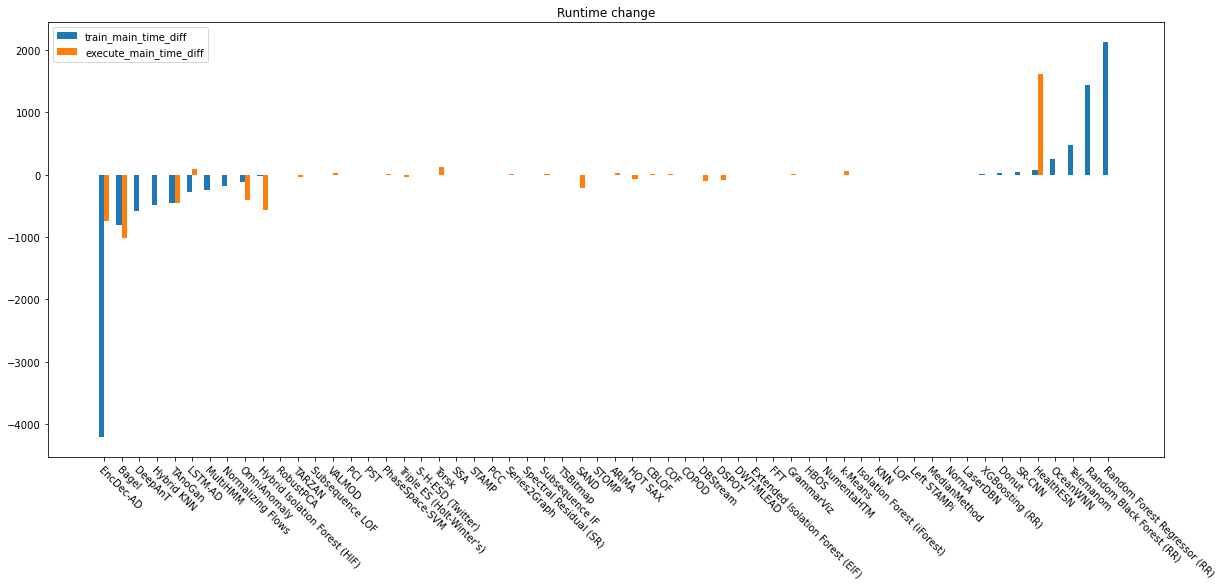

In [22]:
plot_bars(df, columns=["train_main_time_diff", "execute_main_time_diff"], title="Runtime change")
plt.show()